# Zindi ARC Competition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install numpy pandas matplotlib transformers accelerate bitsandbytes -qqq

# Libs

In [3]:
import csv

from datetime import datetime

import numpy as np

import os.path as osp

import pandas as pd
from pathlib import Path
from pprint import pprint

import random

import sys
sys.path.append("../")

import time
from tqdm.auto import tqdm
import torch

In [4]:
from src.config import Config
from src.utils import (load_data, 
                        sample_arc_task,
                        plot_random,
                        visualize_task, 
                        reconstruct_grids, 
                        get_grid_shape,
                        get_row_sizes,
                        infer_out_shape,
                        generate_submission)
from src.model import ARCModel

# Dataset

In [5]:
train_data, test_data = load_data(data_path=Config.data_path)

print(f"✓ Loaded {len(train_data)} training problems")
print(f"✓ Loaded {len(test_data)} test problems")

✓ Loaded 746 training problems
✓ Loaded 185 test problems


In [6]:
example_task_id, example_task = sample_arc_task(train_data, split=None)

test_output = example_task["test"][0]["output"] if "output" in example_task["test"][0].keys() else None

print(f"Sampled task: {example_task_id}")

Sampled task: train_0018


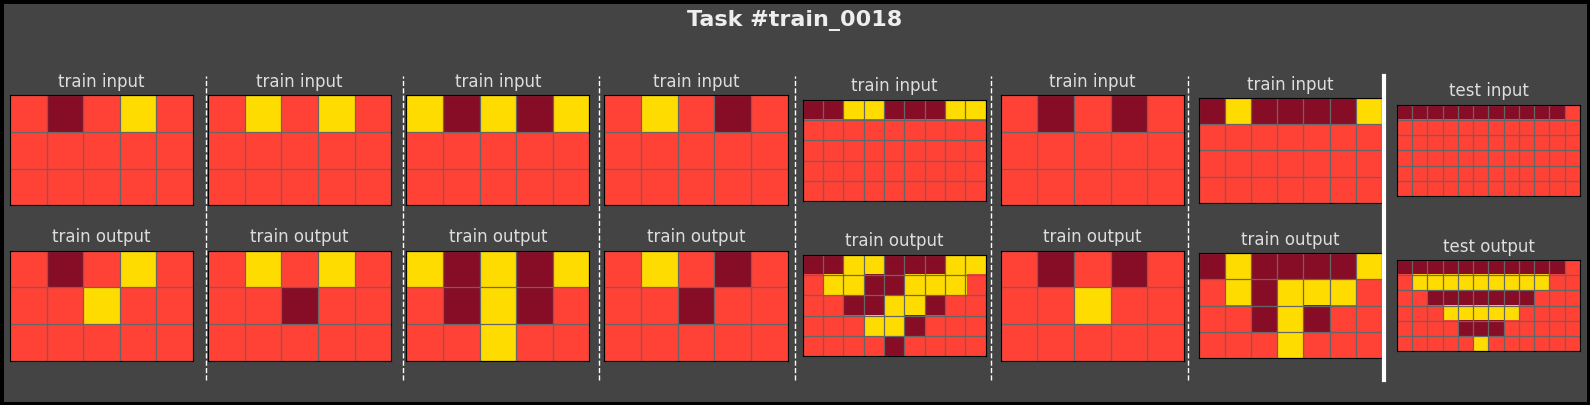

In [7]:
#visualize_task(task_data=train_data["train_0289"],task_id="train_0289", size=2.0, w1=.9)
visualize_task(task_data=example_task,task_id=example_task_id, size=2.0, w1=.9)

In [8]:
n = 10
num_matches = 0
missed = []

for task_id in train_data.keys():
    task = train_data[task_id]

#for _ in range(n):
    #task_id, task = sample_arc_task(train_data, split=None)
    #print(f"Sampled task: {task_id}")

    test_in = task["test"][0]["input"]
    test_in_shape = get_grid_shape(test_in)
    #print("Input shape: \t", test_in_shape)
    
    num_rows = len(task["test"][0]["output"]) if "output" in task["test"][0].keys() else None
    
    inferred_out_shape = infer_out_shape(
        train_pairs=task["train"], 
        test_input=test_in,
        expected_rows=num_rows,
        verbose=False
    )

    #print("Predicted: \t", inferred_out_shape)

    if num_rows is not None:
        test_out_shape = get_grid_shape(task["test"][0]["output"])
        match = inferred_out_shape == test_out_shape
        #print("Actual: \t", test_out_shape)
        #print("Match: \t", match)
        if match == True:
            num_matches+=1
        else:
            missed.append(task_id)

            
match_acc = num_matches/n
pct_missed = 100*len(missed) / len(train_data)

print(f"Match acc: \t{match_acc:.3f}")
print(f"Pct missed: \t{pct_missed:.3f}%")


Match acc: 	65.000
Pct missed: 	12.869%


# Model

In [9]:
%%time

base_prompt_path = "../src/base_prompt.txt"
model = ARCModel(
    system_prompt_path=base_prompt_path, 
    base_llm_name=None,
    verbose=False
)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.77 μs


In [10]:
%%time

preds = model.solve(example_task)

CPU times: user 11 μs, sys: 0 ns, total: 11 μs
Wall time: 12.2 μs


In [11]:
task_solutions = {
    f"{example_task_id}": preds
}

task_solutions

{'train_0018': [[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2],
  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]}

In [12]:
if test_output:
    pprint(test_output)
    metrics = model.evaluate(example_task, preds)
    print(metrics)

[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2],
 [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2],
 [2, 2, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2],
 [2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 2, 2],
 [2, 2, 2, 2, 9, 9, 9, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2]]
{'exact_match': 0.0, 'mean_pixel_accuracy': 0.0}


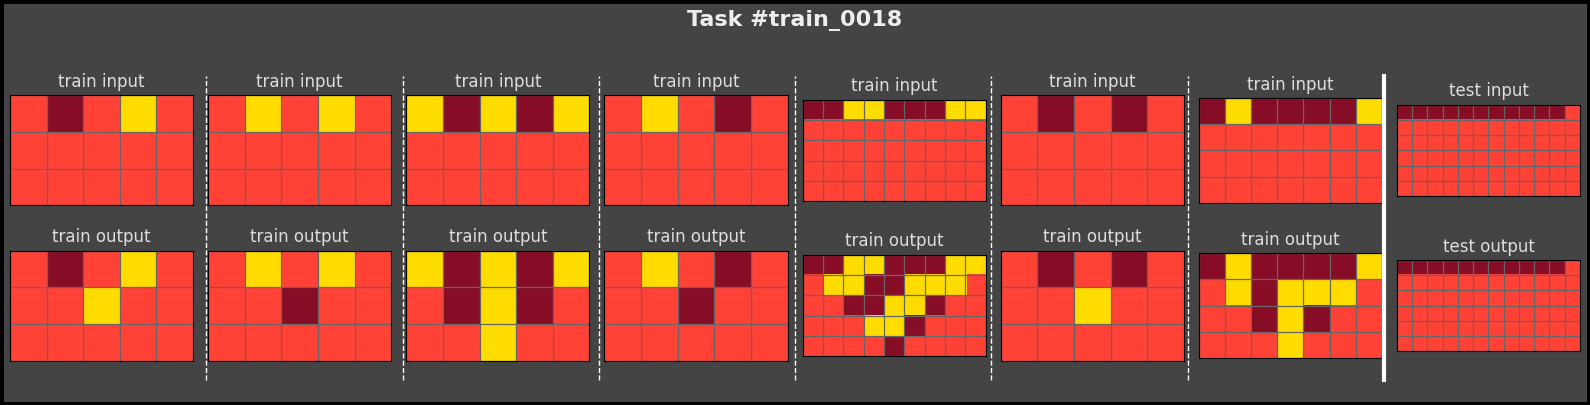

In [13]:
visualize_task(
    task_data=example_task,task_id=example_task_id, size=2.0, w1=.9, task_solutions=task_solutions)

# Run on Training Set

In [14]:
total_match = 0
total_pix_acc = 0
train_preds = []

for task_id in train_data.keys():
    task = train_data[task_id]
    pred = model.solve(task)
    train_preds.append(pred)

    metrics = model.evaluate(task, [pred])
    match, pix_acc = metrics.values()

    total_match+=match
    total_pix_acc+=pix_acc

avg_acc = total_match/len(train_data)
avg_pix_acc = total_pix_acc/len(train_data)

print(f"{avg_acc*100:.5f}% correct matches with {avg_pix_acc*100:.5f}% pixel acc")

0.40214% correct matches with 59.48913% pixel acc


# Run on Test Set

In [15]:
# Load sample submission to see the format
ss = pd.read_csv(
    osp.join(Config.data_path, 'SampleSubmission.csv'),
    dtype={"row": str}
)

print(f"✓ Sample submission has {len(ss)} predictions")

✓ Sample submission has 2303 predictions


In [16]:
test_out_rows = get_row_sizes(ss)
test_out_rows

,ID_,n_rows
0,test_0000,10
1,test_0001,12
2,test_0002,10
3,test_0003,8
4,test_0004,30
...,...,...
180,test_0180,25
181,test_0181,10
182,test_0182,19
183,test_0183,10


In [17]:
test_out_rows.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_rows,185.0,12.448649,7.509328,1.0,8.0,10.0,16.0,30.0


In [18]:
test_preds = []

for task_id, n_out_rows in zip(test_data.keys(), test_out_rows.n_rows.values):
    task = test_data[task_id]
    pred = model.solve(task, n_out_rows)
    test_preds.append(pred)

# Submission

In [19]:
date_str = datetime.now().strftime("%Y-%m-%d")
sub_filename = f"{date_str}-submission-{Config.model_name}-{Config.experiment}"

out_path = osp.join(Config.submission_path, sub_filename)

generate_submission(
    model, 
    test_data, 
    expected_rows_list=test_out_rows.n_rows.values, 
    output_path=out_path
)

✅ Submission saved to ../submissions/2025-07-29-submission-arc-solver-cp-baseline-cp-col-adj


In [20]:
submision = pd.read_csv(out_path)
submision

,ID,row
0,test_0000_1,7777777777
1,test_0000_2,7557775557
2,test_0000_3,7757777757
3,test_0000_4,7577777577
4,test_0000_5,7555775555
...,...,...
2298,test_0184_6,7787533335333777777
2299,test_0184_7,7787537775783777777
2300,test_0184_8,7787537775783777777
2301,test_0184_9,7787555555783777777


In [21]:
submision.shape == ss.shape

True

In [22]:
sum(submision.ID == ss.ID)/ ss.shape[0]

1.0

In [23]:
predictions = reconstruct_grids(submision)

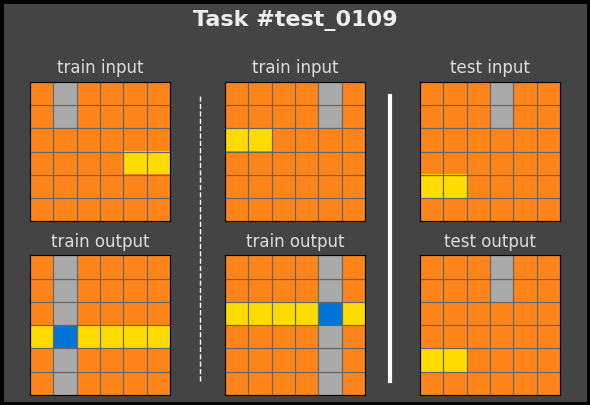

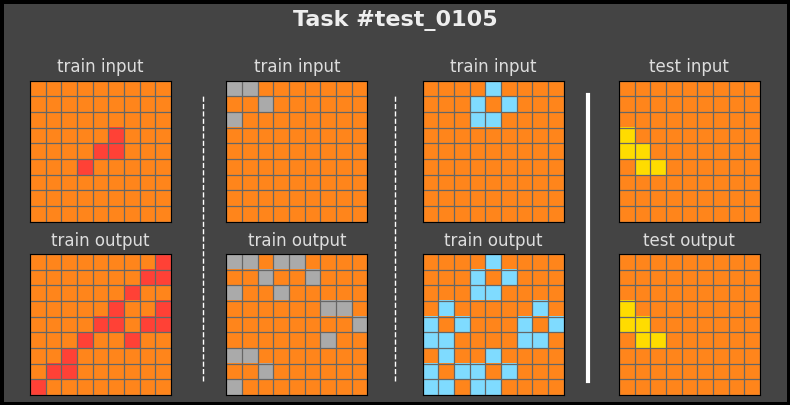

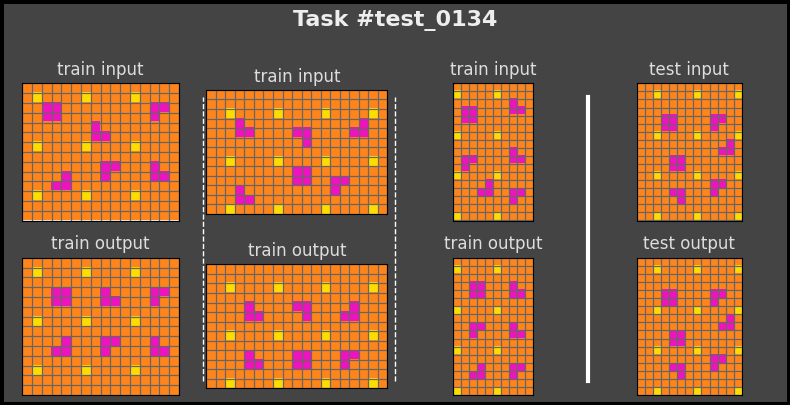

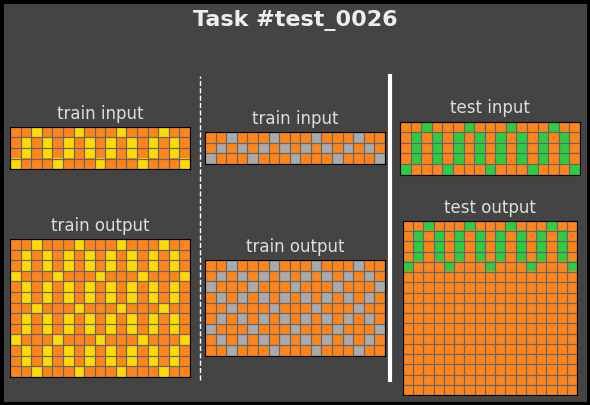

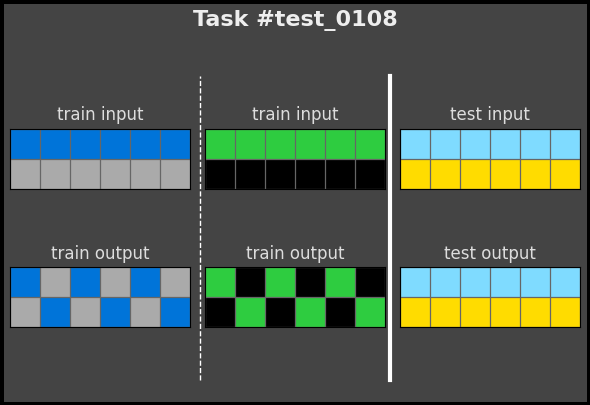

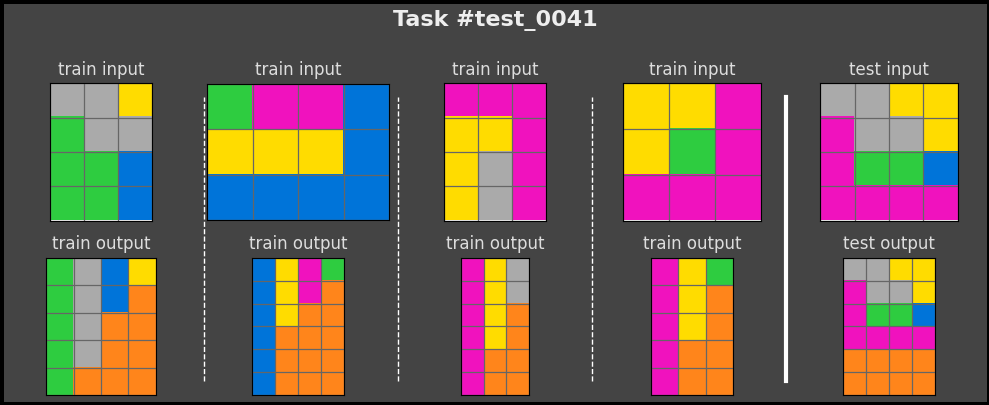

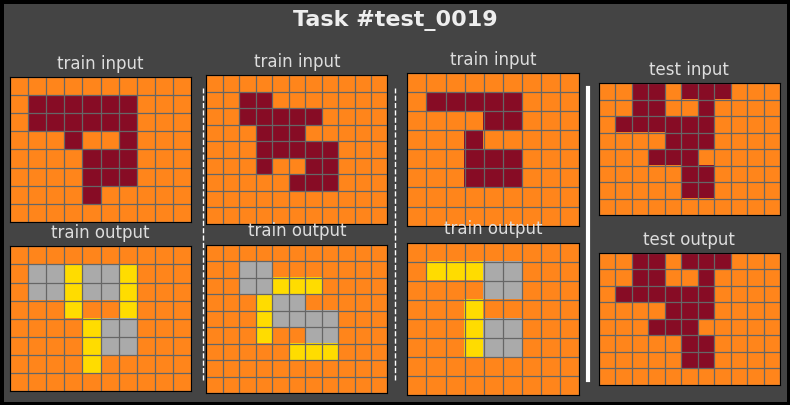

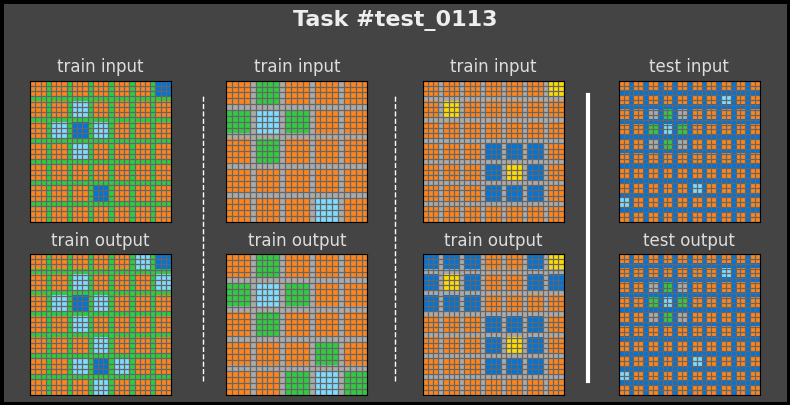

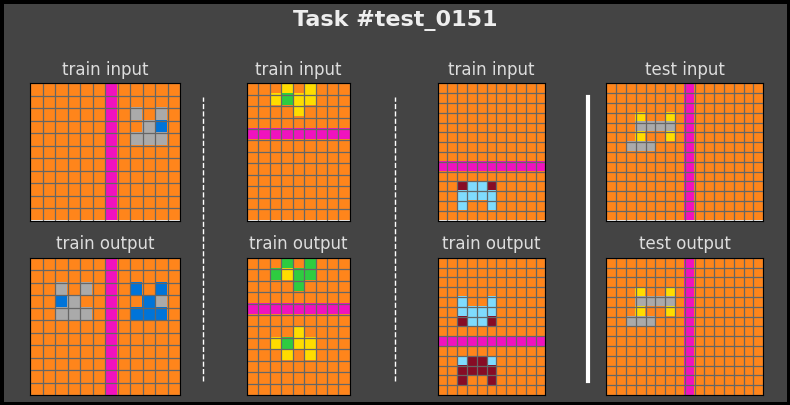

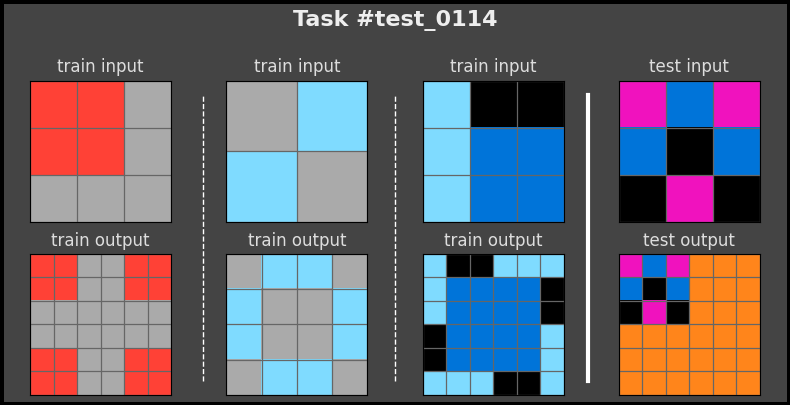

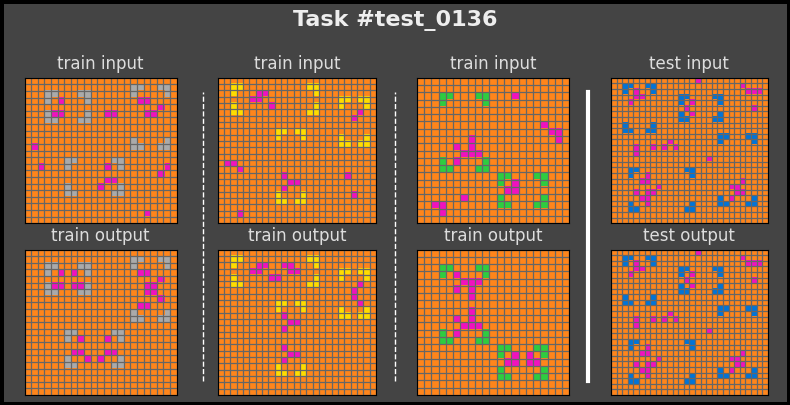

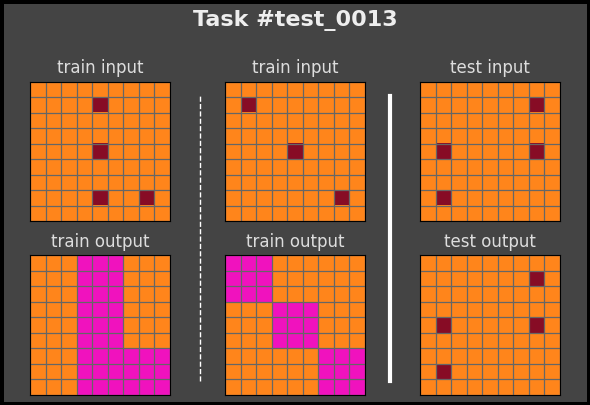

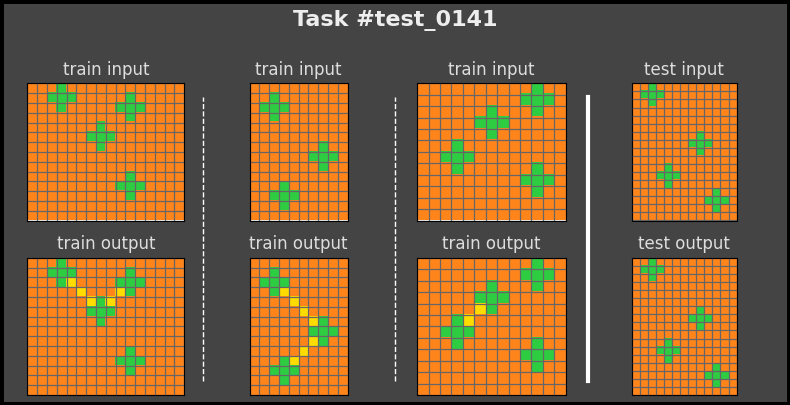

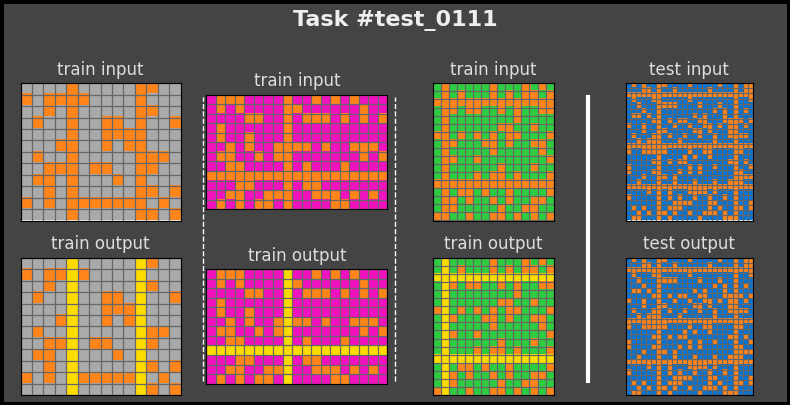

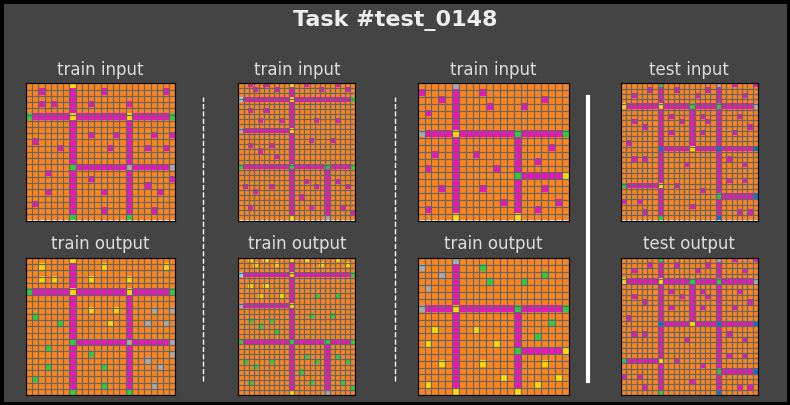

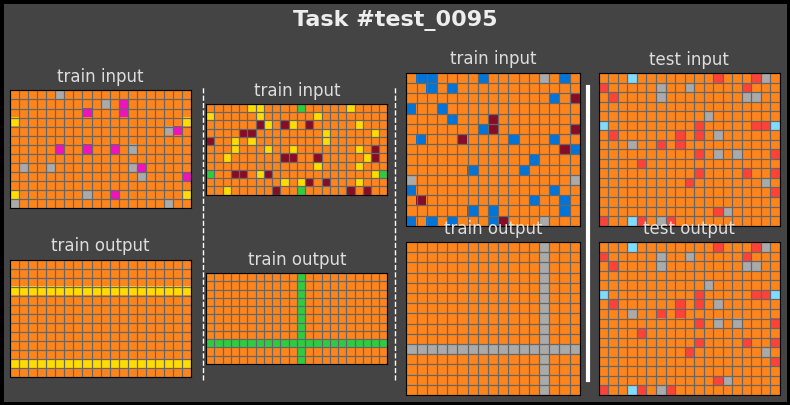

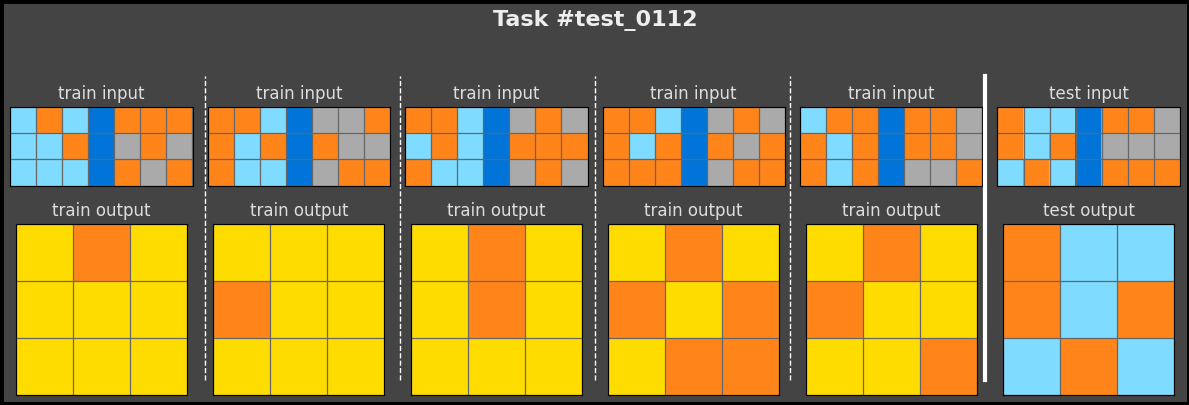

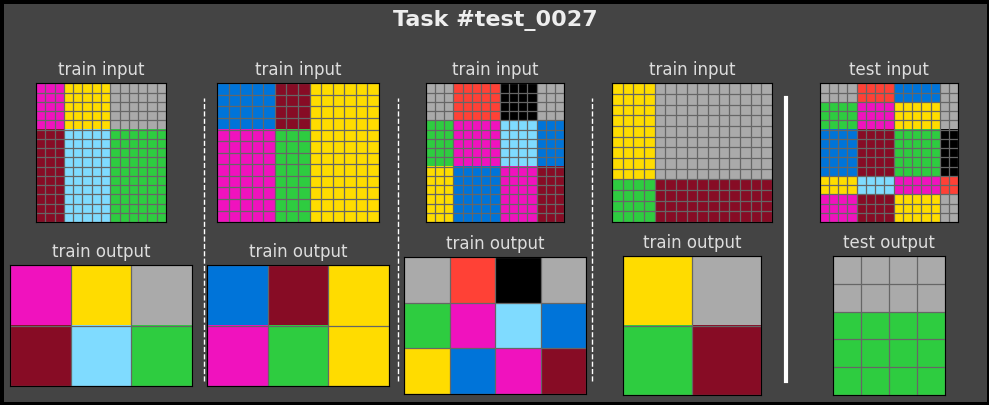

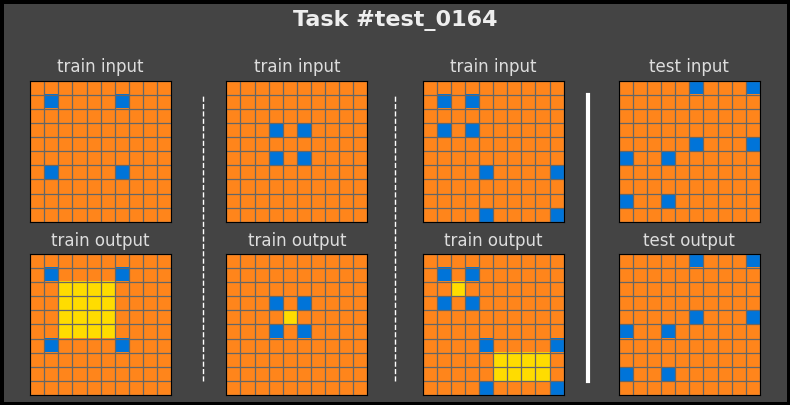

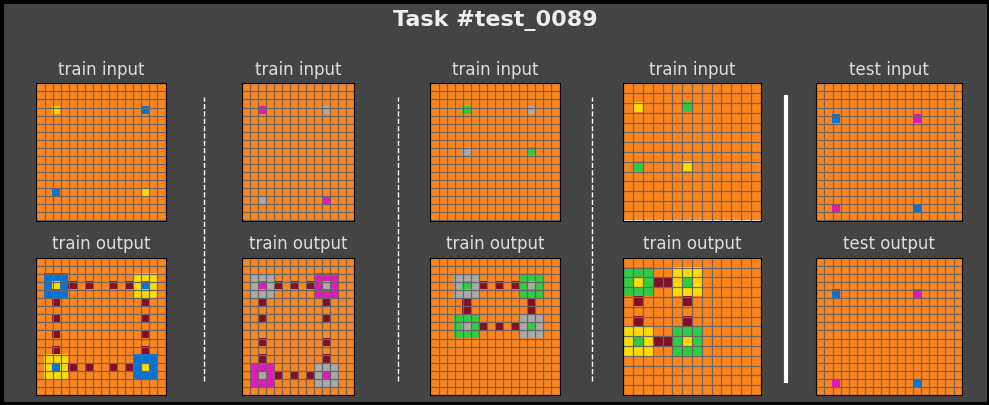

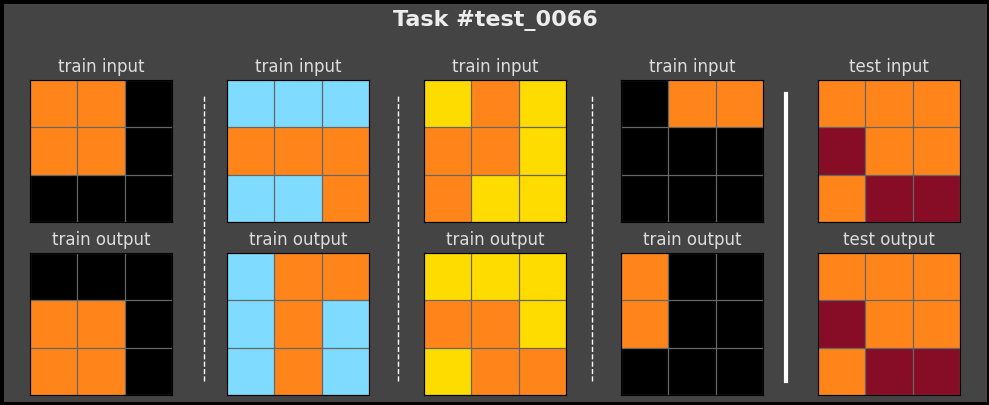

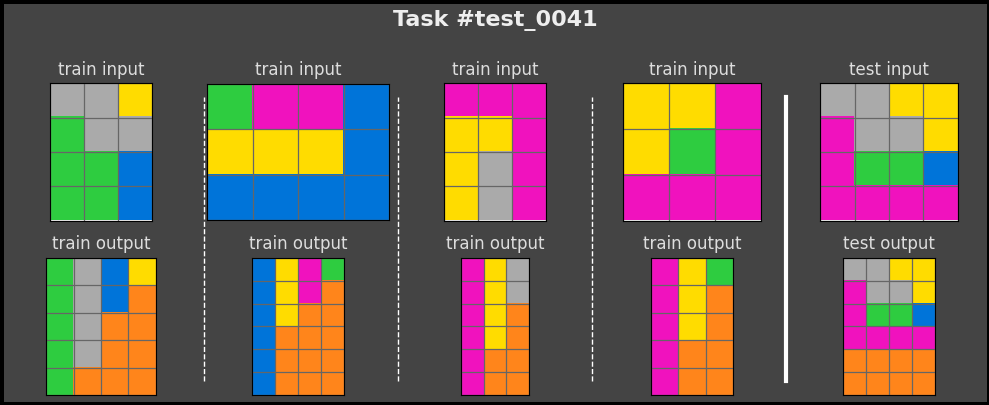

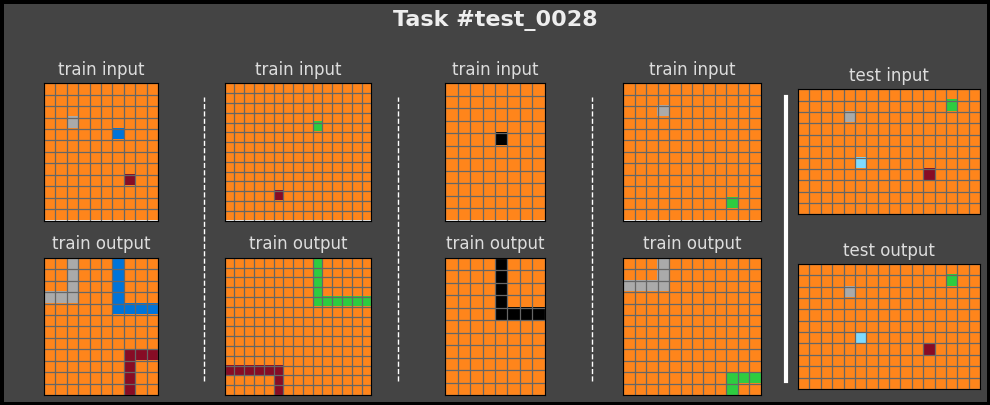

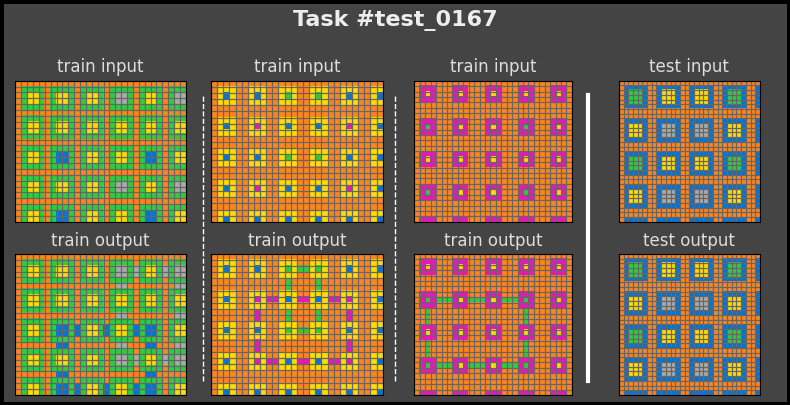

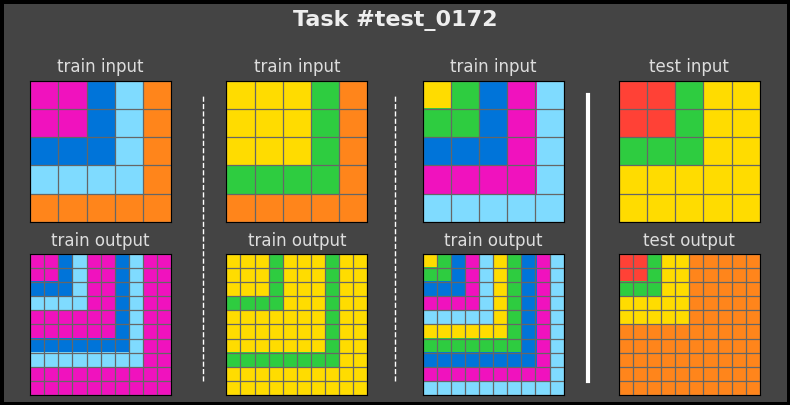

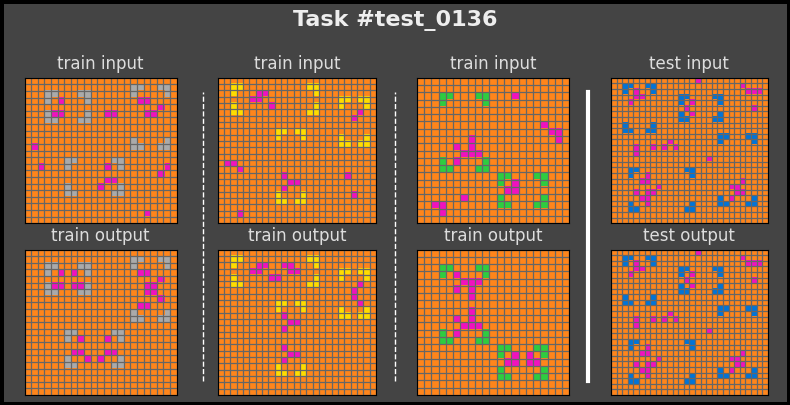

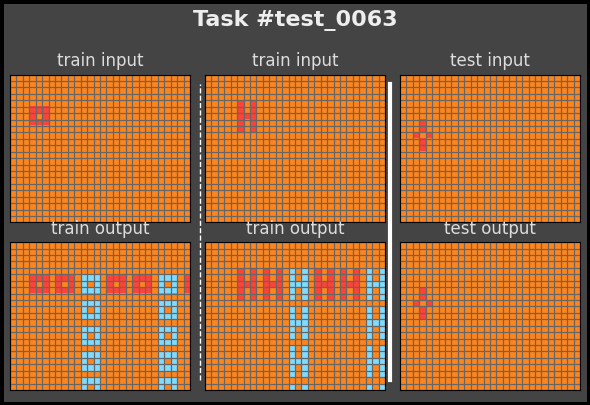

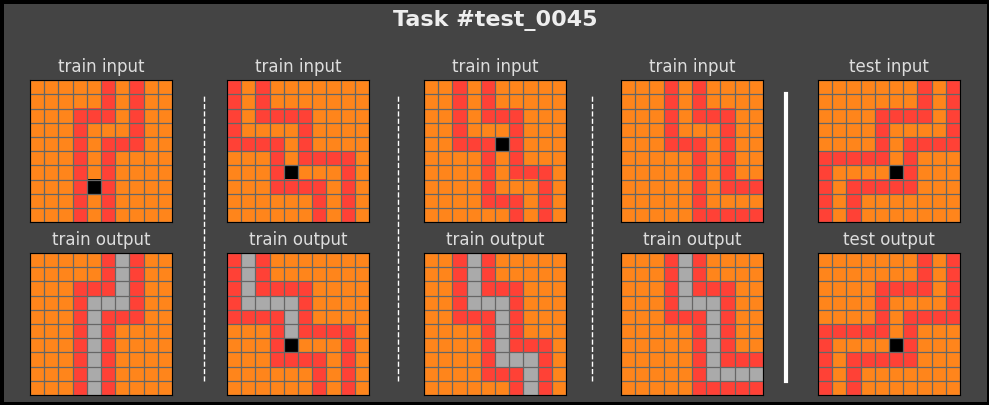

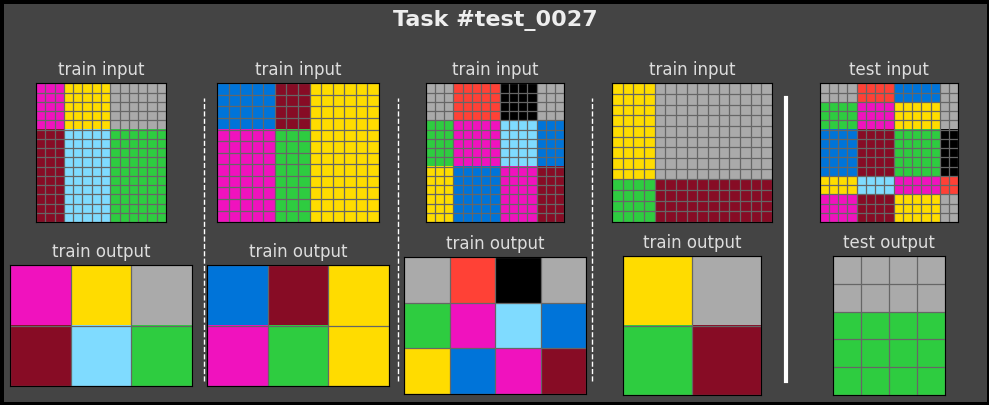

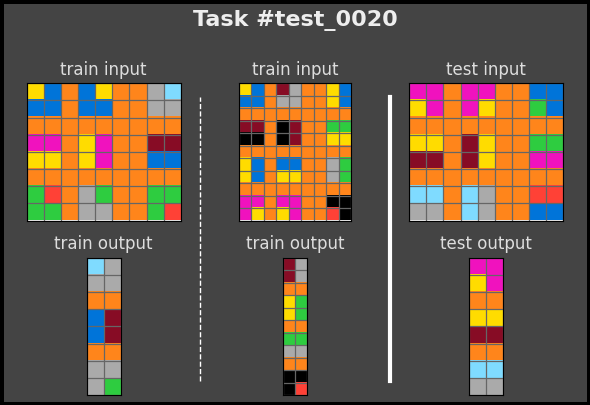

In [24]:
for i in range(30):
    task_id, task_data = sample_arc_task(test_data, split=None)    
    visualize_task(task_data=task_data,task_id=task_id, size=2.0, w1=.9, task_solutions=predictions)